In [1]:
from Dataset.dataset import Eve, Bars3D, Points3D
import numpy as np
from sksurv.ensemble import RandomSurvivalForest
import pickle
from model import XSurvKMeansRF
import time
import matplotlib.pyplot as plt

C:\Users\Abd\AppData\Local\conda\conda\envs\hh\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset Description =======================
Dataset Name: Points3D
Dataset Shape: (9000, 5)
Events: 30.18 %
NaN Values: 0.00 %
Events % in splits: 30.17, 30.17, 30.17, 30.22, 30.17, 



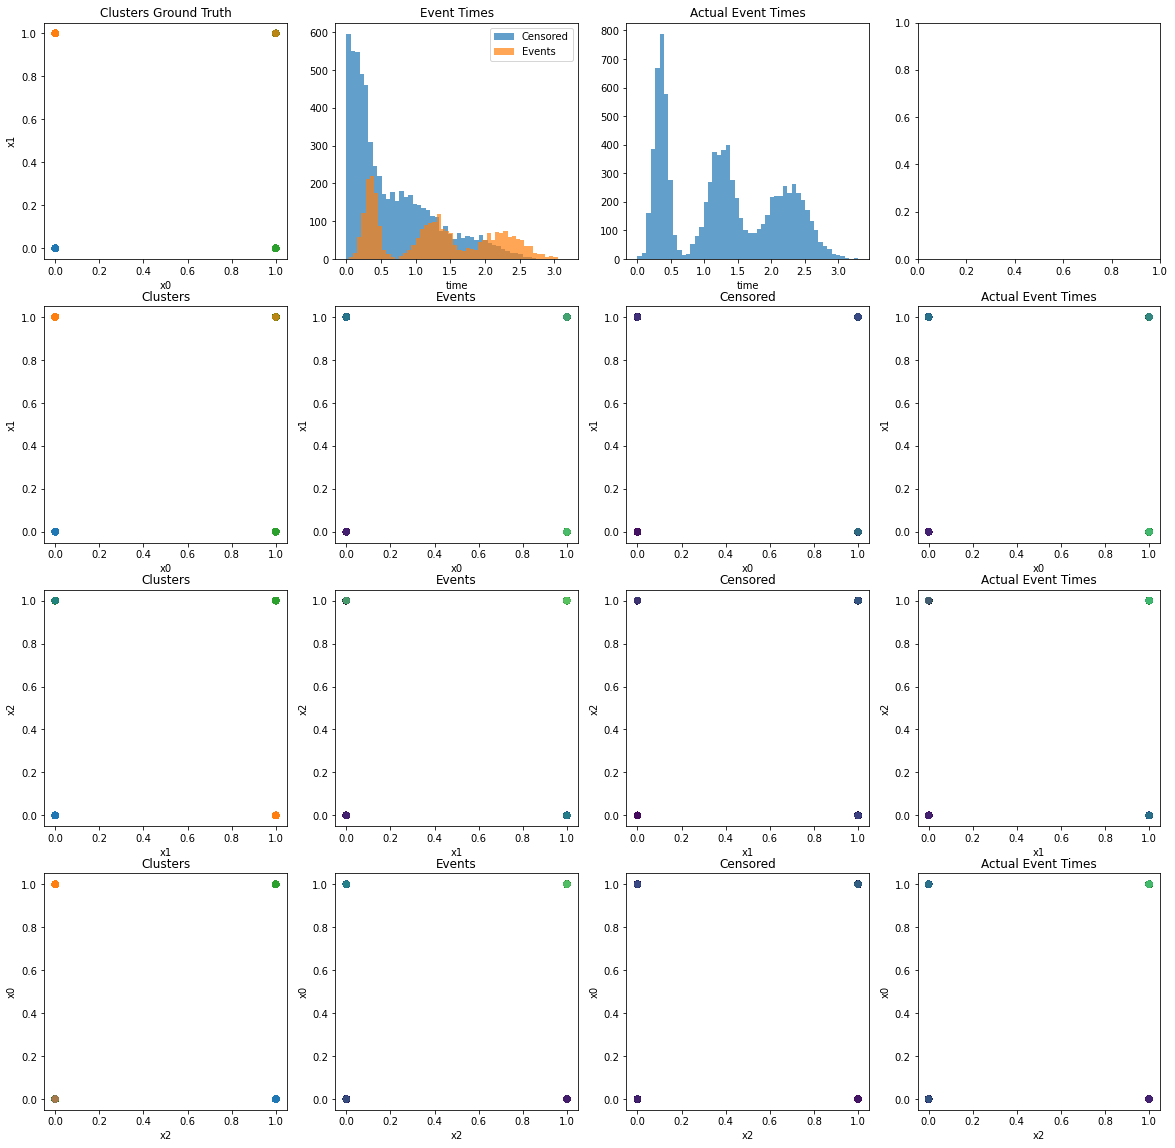

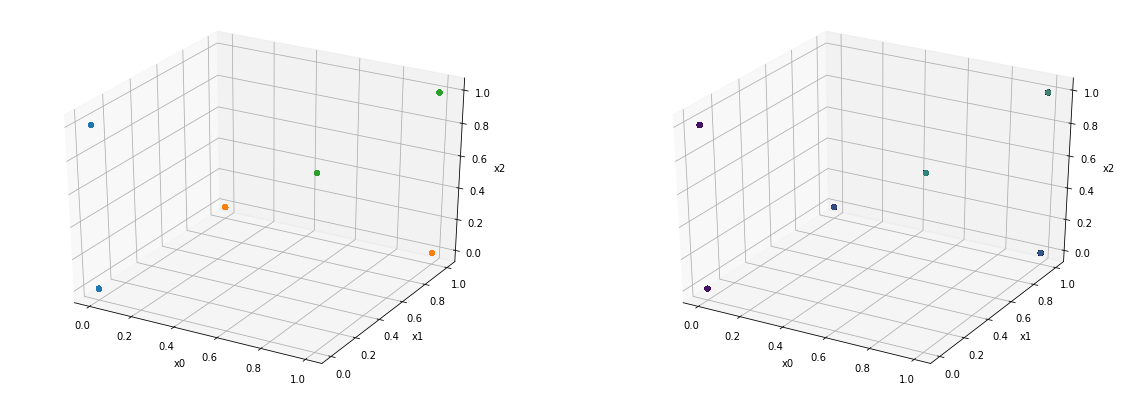

In [2]:
ds = Points3D()

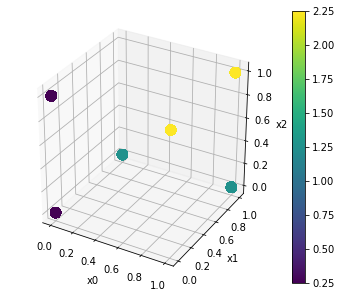

In [3]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

cax = ax.scatter(ds.sdata.x[:, 0], ds.sdata.x[:, 1], ds.sdata.x[:, 2], c=ds.sdata.c+0.25, alpha=1, s=100)
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
fig.colorbar(cax)

# ax = fig.add_subplot(122, projection='3d')
# ax.scatter(sdata.x[:, 0], sdata.x[:, 1], sdata.x[:, 2], c=sdata.t, alpha=0.2)
# ax.set_xlabel('x0')
# ax.set_ylabel('x1')
# ax.set_zlabel('x2')
plt.savefig('Results/Points3D/original_x.pdf', format='pdf', bbox_inches='tight')

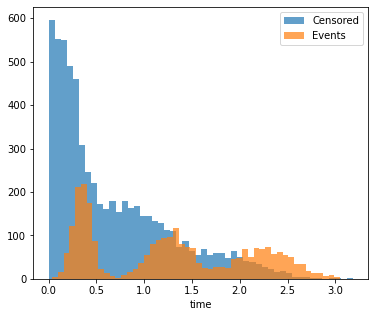

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.hist(ds.sdata.t[ds.sdata.e == 0], bins=50, alpha=0.7, label='Censored');
ax.hist(ds.sdata.t[ds.sdata.e == 1], bins=50, alpha=0.7, label='Events');
ax.set_xlabel('time')
#ax[0].set_title('Event Times')
ax.legend()

# ax[1].hist(ds.sdata.t_uncensored, bins=50, alpha=0.7);
# ax[1].set_xlabel('time')
#ax[1].set_title('Actual Event Times')
plt.savefig('Results/Points3D/sim_time_c.pdf', format='pdf', bbox_inches='tight')

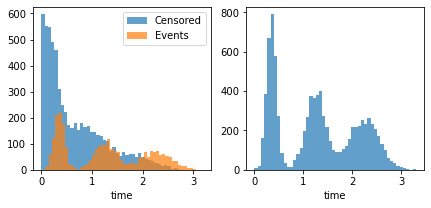

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

ax[0].hist(ds.sdata.t[ds.sdata.e == 0], bins=50, alpha=0.7, label='Censored');
ax[0].hist(ds.sdata.t[ds.sdata.e == 1], bins=50, alpha=0.7, label='Events');
ax[0].set_xlabel('time')
#ax[0].set_title('Event Times')
ax[0].legend()

ax[1].hist(ds.sdata.t_uncensored, bins=50, alpha=0.7);
ax[1].set_xlabel('time')
#ax[1].set_title('Actual Event Times')
plt.savefig('Results/Points3D/sim_time.pdf', format='pdf', bbox_inches='tight')

In [6]:
(x_train, ye_train, y_train, e_train,
 x_val, ye_val, y_val, e_val,
 x_test, ye_test, y_test, e_test) = ds.get_train_val_test_from_splits(test_id=0, val_id=1)
 #train_df_orig, val_df_orig, test_df_orig) = ds.get_train_val_test_from_splits(test_id=0, val_id=1)

print('Testing on %d-----------------------------' % 1)
print(x_train.shape, x_val.shape)

Testing on 1-----------------------------
(5400, 3) (1800, 3)


In [7]:
# special for RSF
dt = np.dtype('bool,float')
y_train_surv = np.array([(bool(e), y) for e, y in zip(e_train, y_train)], dtype=dt)
y_val_surv = np.array([(bool(e), y) for e, y in zip(e_val, y_val)], dtype=dt)
print(y_train_surv.shape, y_val_surv.shape)

# train RSF
rsf = RandomSurvivalForest(n_estimators=50,
                           min_samples_split=5,
                           min_samples_leaf=5,
                           max_features="sqrt",
                           oob_score=True,
                           n_jobs=-1,
                           random_state=20)
rsf.fit(x_train, y_train_surv)
pickle.dump(rsf, open('Results/Points3D/Points3D_rsf_model.mdl', 'wb'))

#rsf = pickle.load(open('Points3D_rsf_model.mdl', 'rb'))



(5400,) (1800,)


In [8]:
cindex_train = rsf.score(x_train, y_train_surv)
cindex_oob = rsf.oob_score_
cindex_val = rsf.score(x_val, y_val_surv)
cindex_val_events = rsf.score(x_val[e_val==1], y_val_surv[e_val==1])

print('Train cindex {:.2f}'.format(cindex_train*100))
print('Test cindex {:.2f}'.format(cindex_val*100))
print('Test cindex Events Only {:.2f}'.format(cindex_val_events*100))

Train cindex 89.22
Test cindex 88.79
Test cindex Events Only 83.19


In [9]:
surv_train = rsf.predict_survival_function(x_train, return_array=True)
surv_val = rsf.predict_survival_function(x_val, return_array=True)
surv_test = rsf.predict_survival_function(x_test, return_array=True)



#Explanation
xte_data = (x_train, y_train, e_train,
            x_val, y_val, e_val,
            x_test, y_test, e_test)

survival_curves = (surv_train, surv_val, surv_test)

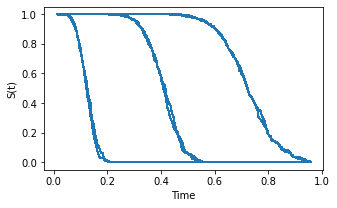

In [29]:
plt.figure(figsize=(5,3))
for s in surv_test:
    plt.step(rsf.event_times_,s, alpha=0.01, c='C0')
plt.xlabel('Time')
plt.ylabel('S(t)')
plt.savefig('Results/Points3D/rsf_survival_funcs.pdf', format='pdf', bbox_inches='tight')

shape: 1630


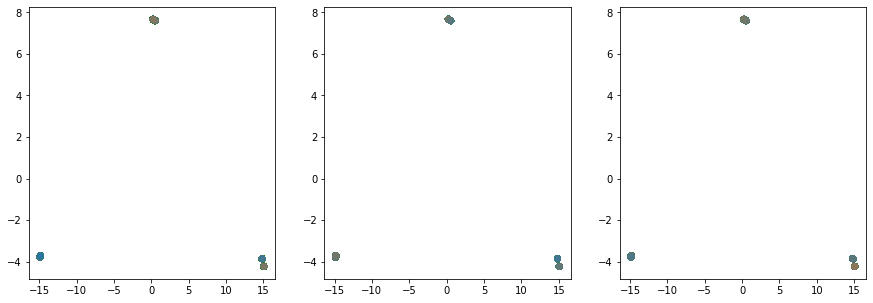

Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
Number of distinct clusters (6) found smaller than n_clusters (11). Possibly due to duplicate points in X.
Number of distinct clusters (6) found smaller than n_clusters (12). Possibly due to duplicate points in X.
Number of distinct clusters (6) found smaller than n_clusters (13). Possibly due to duplicate points in X.
Number of distinct clusters (6) found smaller than n_clusters (14). Possibly due to duplicate points in X.


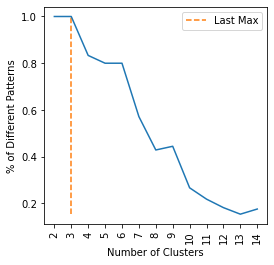

<Figure size 360x360 with 0 Axes>

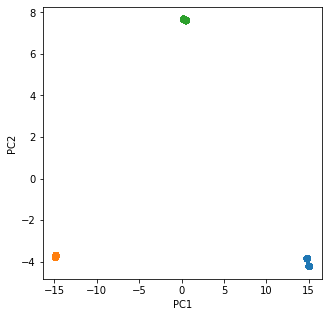

<Figure size 360x360 with 0 Axes>

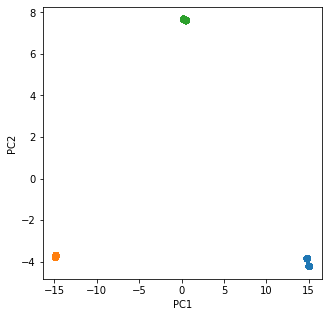

<Figure size 360x360 with 0 Axes>

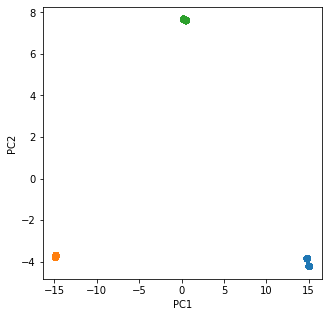

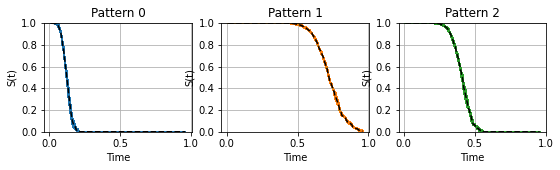

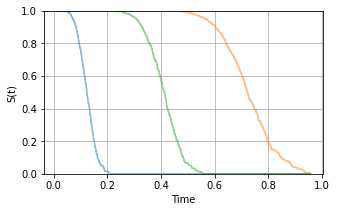

In [10]:
explainer = XSurvKMeansRF(prefix_name='Points3D', max_k=15, z_explained_variance_ratio_threshold=0.99, curves_diff_significance_level=0.05)
explainer.fit(xte_data=xte_data, survival_curves=survival_curves, event_times=rsf.event_times_)#, pretrained_clustering_model="clustering_model_eve_9_20220223-152051.mdl", k=9)

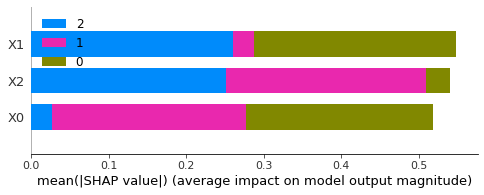

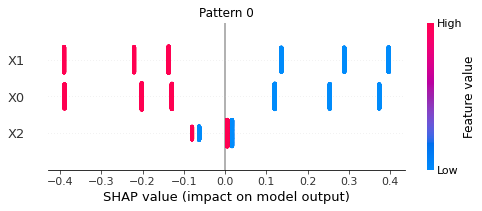

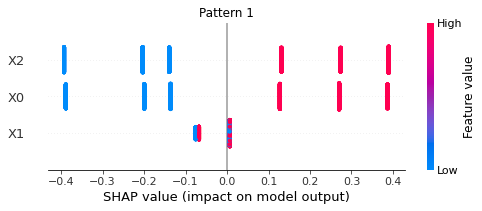

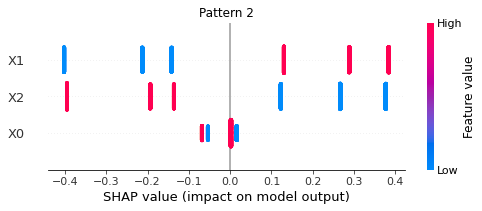

In [11]:
shap_values_train = explainer.explain(x=x_train, features_names_list=ds.features_names, suffex='train')

Text(0.5, 0, 'x2')

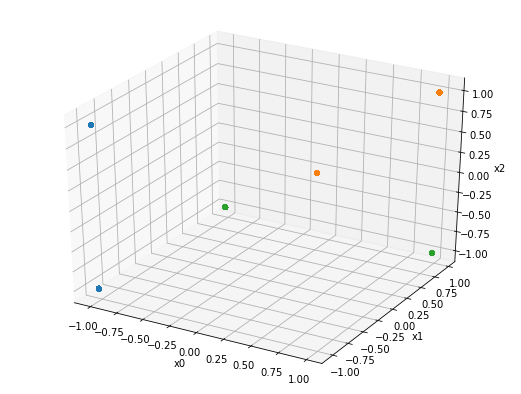

In [12]:

def getc(c):
    return [f'C{i}' for i in c]

fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(121, projection='3d')

ax.scatter(x_train[:, 0], x_train[:, 1], x_train[:, 2], c=getc(explainer.labels_train), alpha=0.2)
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')

In [13]:
rs = rsf.predict(x_train)
h = rs

Text(0.5, 0, 'x2')

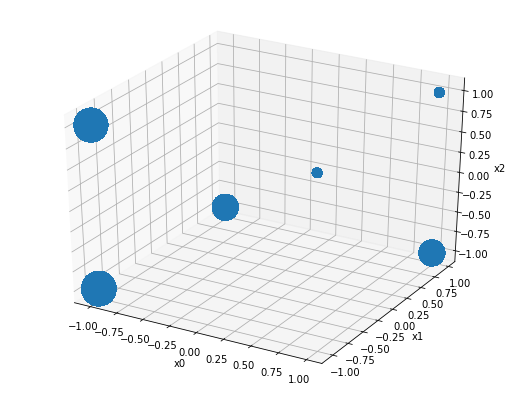

In [14]:
import matplotlib.pyplot as plt
def getc(c):
    return [f'C{i}' for i in c]

fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(121, projection='3d')

ax.scatter(x_train[:, 0], x_train[:, 1], x_train[:, 2], s=h/5, alpha=0.2)
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
#plt.colorbar()

In [15]:
ds.sdata.t_uncensored

array([0.43682858, 2.30719878, 0.38419292, ..., 0.23276305, 0.57402509,
       0.2979067 ])

Text(0.5, 0, 'x2')

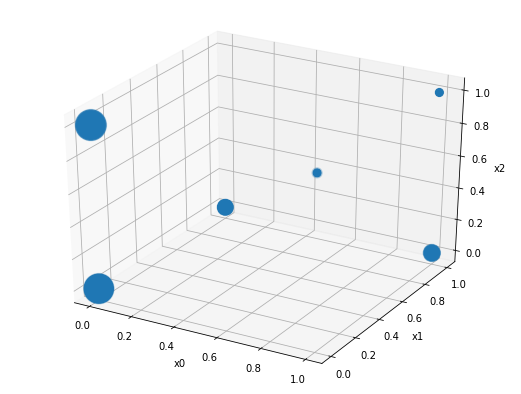

In [16]:
import matplotlib.pyplot as plt
def getc(c):
    return [f'C{i}' for i in c]

fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(121, projection='3d')

ax.scatter(ds.sdata.x[:, 0], ds.sdata.x[:, 1], ds.sdata.x[:, 2], s=(np.exp(-(ds.sdata.t_uncensored*2)))*1000, alpha=0.2)
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
#plt.colorbar()

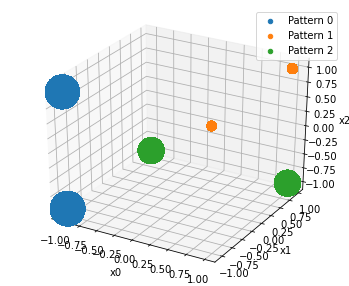

In [17]:
import matplotlib.pyplot as plt
def getc(c):
    return [f'C{i}' for i in c]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

for i in range(3):
    f = explainer.labels_train == i
    ax.scatter(x_train[f, 0], x_train[f, 1], x_train[f, 2], s=h[f]/5, c=f'C{i}', alpha=1, label=f'Pattern {i}')
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
lgnd = ax.legend()
for handle in lgnd.legendHandles:
    handle.set_sizes([20])
#plt.colorbar()
plt.savefig('Results/Points3D/points_x_patterns_rsf.pdf', format='pdf', bbox_inches='tight')

Text(0.5, 0, 'x2')

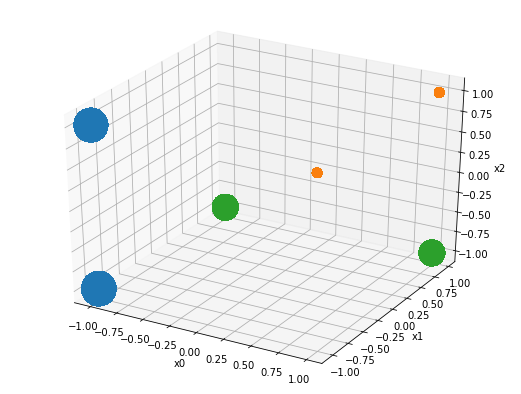

In [18]:
import matplotlib.pyplot as plt
def getc(c):
    return [f'C{i}' for i in c]

fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(121, projection='3d')

ax.scatter(x_train[:, 0], x_train[:, 1], x_train[:, 2], s=h/5, c=getc(explainer.labels_train), alpha=0.2)
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
#plt.colorbar()

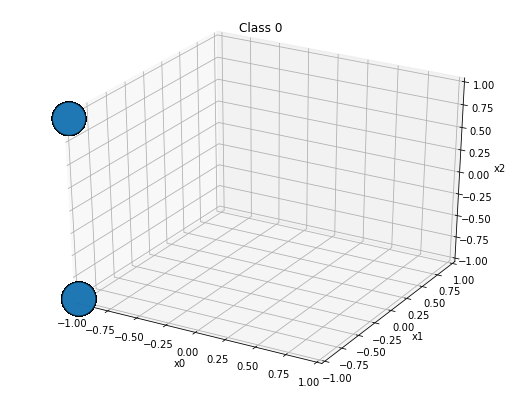

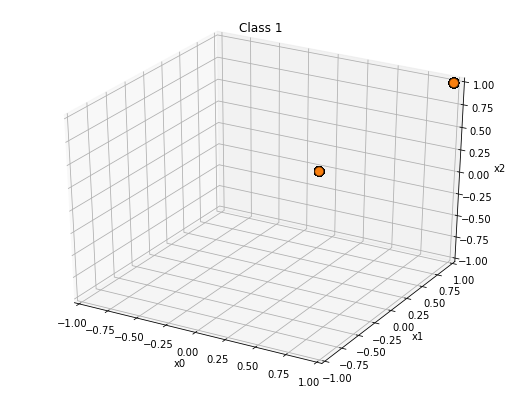

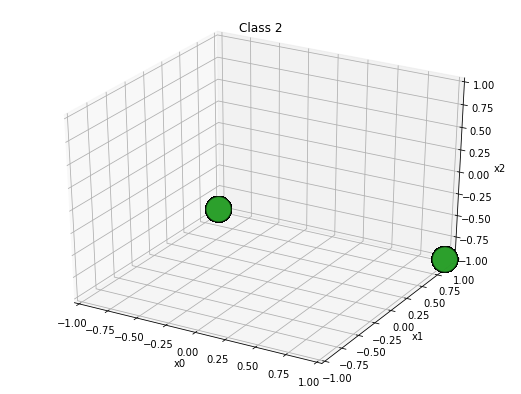

In [19]:
for i in range(len(set(explainer.labels_train))):
    
    f = (explainer.labels_train == i)

    fig = plt.figure(figsize=(20, 7))
    ax = fig.add_subplot(121, projection='3d')

    ax.scatter(x_train[f, 0], x_train[f, 1], x_train[f, 2], s=h[f]/5, c=getc(explainer.labels_train[f]), alpha=0.2, edgecolors='black')
    ax.set_xlabel('x0')
    ax.set_ylabel('x1')
    ax.set_zlabel('x2')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    #plt.colorbar()
    plt.title(f'Class {i}')

In [20]:
data = np.random.uniform(low=-1, high=1, size=(50000,3))
data.shape

(50000, 3)

In [21]:
data_rs = rsf.predict(data)
data_h = data_rs

Text(0.5, 0, 'x2')

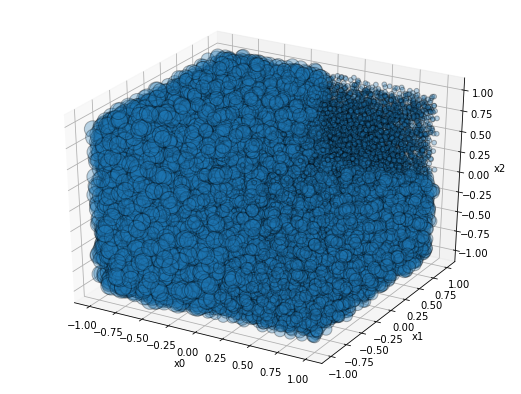

In [22]:
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2],s=data_h/20, alpha=0.3, edgecolors='black')
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')

In [23]:
data_labels = explainer.classication_model.predict(data)

Text(0.5, 0, 'x2')

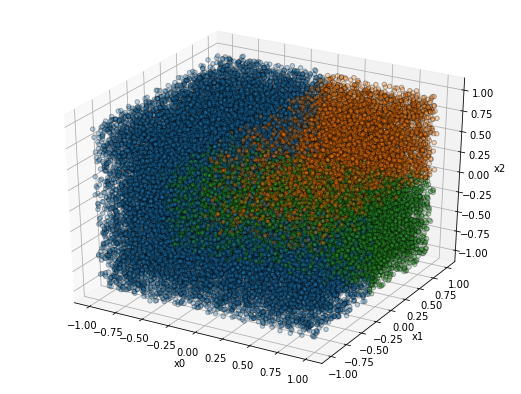

In [24]:
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=getc(data_labels), alpha=0.3, edgecolors='black')
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')

Text(0.5, 0, 'x2')

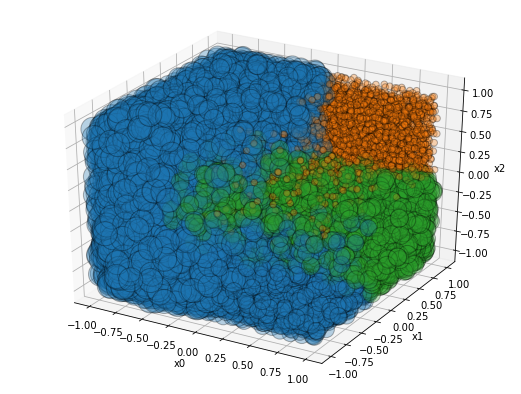

In [25]:
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], s=data_h/10, c=getc(data_labels), alpha=0.3, edgecolors='black')
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')

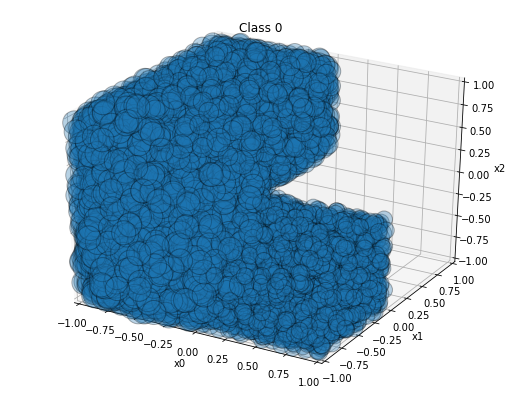

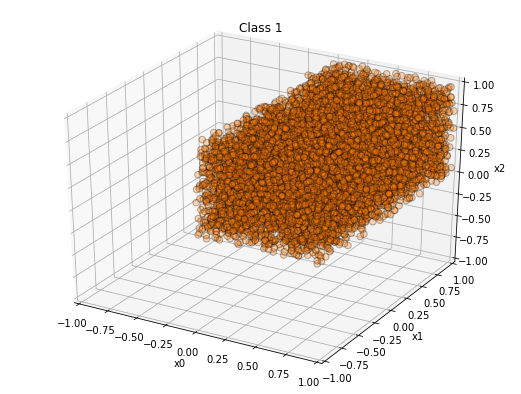

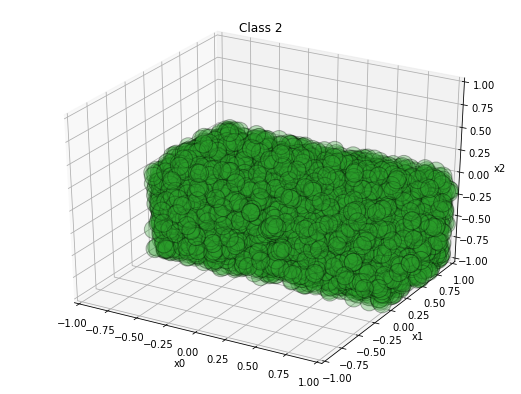

In [26]:
for i in range(len(set(data_labels))):
    f = (data_labels == i)
    fig = plt.figure(figsize=(20, 7))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(data[f, 0], data[f, 1], data[f, 2], s=data_h[f]/10, c=getc(data_labels[f]), alpha=0.3, edgecolors='black')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    ax.set_xlabel('x0')
    ax.set_ylabel('x1')
    ax.set_zlabel('x2')
    plt.title(f'Class {i}')

In [27]:
#shap_values_val = explainer.explain(x=x_val, features_names_list=ds.features_names, suffex='val')

In [28]:
#shap_values_test = explainer.explain(x=x_test, features_names_list=ds.features_names, suffex='test')